In [70]:
import os
import matplotlib.pyplot as pit
from nilearn.image import mean_img,load_img
from nilearn.plotting import plot_stat_map, plot_anat, plot_img,show, plot_glass_brain
from bids.layout import BIDSLayout
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import nibabel as nib
import numpy as np 
import networkx as nx

%matplotlib inline

In [3]:
fmriprep_dir='../Full-Dataset'
layout=BIDSLayout(fmriprep_dir)

In [4]:
events=pd.read_table('..\\Full-Dataset\\task-speech_events.tsv')
print(events)

    onset  duration   trial_type
0       0        26  white-noise
1      28        26    sentences
2      56        26        words
3      84        26     reversed
4     112        26  white-noise
5     140        26        words
6     168        26     reversed
7     196        26    sentences
8     224        26  white-noise
9     252        26     reversed
10    280        26    sentences
11    308        26        words
12    336        26  white-noise
13    364        26    sentences
14    392        26     reversed
15    420        26        words
16    448        26  white-noise
17    476        26     reversed
18    504        26        words
19    532        26    sentences
20    560        26  white-noise
21    588        26        words
22    616        26    sentences
23    644        26     reversed


In [82]:
nifti_file_path = "C:\\Users\\kuttysidtej\\Desktop\\Full-Dataset\\sub-32\\func\\sub-32_task-speech_bold.nii.gz"
img = nib.load(nifti_file_path) 


In [171]:
import pandas as pd
import nibabel as nib

def extract_fmri_data(tsv_path, img, condition='sentences', duration=13):
    # Load TSV data into a DataFrame
    df = pd.read_csv(tsv_path, delimiter='\t')

    # Extract time points for the specified condition
    condition_time_points = df.loc[df['trial_type'] == condition, 'onset']

    # Create a list of time points for each occurrence of the specified condition
    condition_occurrences = []
    for onset in condition_time_points:
        condition_occurrences.extend(range(int(onset), int(onset) + duration))

    # Extract corresponding time points from fMRI data
    condition_fmri_data = img.get_fdata()[:, :, :, condition_occurrences]

    return condition_occurrences, condition_fmri_data

# Example usage
tsv_path = 'C:\\Users\\kuttysidtej\\Desktop\\my.tsv'
nifti_img = nib.load('C:\\Users\\kuttysidtej\\Desktop\\Full-Dataset\\sub-32\\func\\sub-32_task-speech_bold.nii.gz')  # Replace with the actual path
condition_occurrences, condition_fmri_data = extract_fmri_data(tsv_path, nifti_img)

# Print or use the extracted fMRI data for the specified condition
print(condition_occurrences)
print(condition_fmri_data.shape)


[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320]
(96, 96, 32, 78)


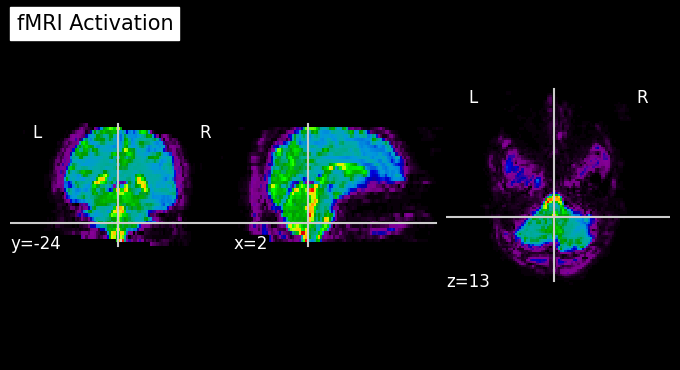

In [168]:
import matplotlib.pyplot as plt
from nilearn import plotting

# Assuming sentences_fmri_data is your 4D fMRI data
# Select a specific volume for visualization
volume_to_plot = 0  # Replace with the index of the volume you want to plot

# Extract the 3D volume
volume_data = sentences_fmri_data[:, :, :, volume_to_plot]

# Create a Nifti1Image
volume_img = nib.Nifti1Image(volume_data, img.affine)

# Plot the 3D volume using nilearn's plot_epi
plotting.plot_epi(epi_img=volume_img, cut_coords=(2, -24, 13), title="fMRI Activation")
plt.show()


In [152]:
from nilearn import datasets, maskers, image, connectome
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
from bids.layout import BIDSLayout
import numpy as np

def create_fc_matrices(sentences_occurrences):
    fmriprep_dir = '../Full-Dataset'
    layout = BIDSLayout(fmriprep_dir)
    msdl_atlas = datasets.fetch_atlas_msdl()

    print(f'Number of labels in the atlas: {len(msdl_atlas.labels)}\n')

    fmri_files = layout.get(datatype='func', extension='.nii.gz', return_type="file")

    print(f'Number of Subjects in the Dataset: {len(fmri_files)}\n')

    masker = maskers.NiftiMapsMasker(maps_img=msdl_atlas.maps, standardize='zscore_sample', verbose=0)
    correlation_measure = connectome.ConnectivityMeasure(kind='correlation', standardize='zscore_sample')

    subject_corr_data = []
    time_series_data = []

    for file in fmri_files:
        fmri_data = image.load_img(file)
        
        # Extract time series for the entire run
        time_series = masker.fit_transform(fmri_data) 

        #print("Shape of time_series:", time_series.shape)
        #print("Maximum index in sentences_occurrences:", max(sentences_occurrences))
        
        # Select only the time points corresponding to "sentences_occurrences"
         

        valid_indices = [idx for idx in sentences_occurrences if idx < time_series.shape[1]] 
        selected_time_series = time_series[:, valid_indices] 
        corr_matrix = correlation_measure.fit_transform([selected_time_series])[0]
        time_series_data.append(selected_time_series)
        subject_corr_data.append(corr_matrix)
        print(f'Subjects left to Compute {len(fmri_files) - len(subject_corr_data)}')

    return subject_corr_data, time_series_data

# Assuming you already have sentences_occurrences from your previous step
# Call the function with the specified time points
subject_corr_data, time_series_data = create_fc_matrices(sentences_occurrences)


Number of labels in the atlas: 39

Number of Subjects in the Dataset: 71

Subjects left to Compute 70
Subjects left to Compute 69
Subjects left to Compute 68
Subjects left to Compute 67
Subjects left to Compute 66
Subjects left to Compute 65
Subjects left to Compute 64
Subjects left to Compute 63
Subjects left to Compute 62
Subjects left to Compute 61
Subjects left to Compute 60
Subjects left to Compute 59
Subjects left to Compute 58
Subjects left to Compute 57
Subjects left to Compute 56
Subjects left to Compute 55
Subjects left to Compute 54
Subjects left to Compute 53
Subjects left to Compute 52
Subjects left to Compute 51
Subjects left to Compute 50
Subjects left to Compute 49
Subjects left to Compute 48
Subjects left to Compute 47
Subjects left to Compute 46
Subjects left to Compute 45
Subjects left to Compute 44
Subjects left to Compute 43
Subjects left to Compute 42
Subjects left to Compute 41
Subjects left to Compute 40
Subjects left to Compute 39
Subjects left to Compute 38
Su

In [153]:
np.save('C:\\Users\\kuttysidtej\\Desktop\\mri-research\\source_data\\fc\\fc_matrices1',subject_corr_data)
np.save("C:\\Users\\kuttysidtej\\Desktop\\mri-research\\source_data\\time_series1",time_series_data)

In [154]:
fc_matrices=np.load("C:\\Users\\kuttysidtej\\Desktop\\mri-research\\source_data\\fc\\fc_matrices1.npy")

In [155]:
msdl_atlas = datasets.fetch_atlas_msdl()
msdl_labels = msdl_atlas.labels
msdl_coords = msdl_atlas.region_coords

In [156]:
len(fc_matrices)

71

In [157]:
def create_knn_graph(fc_matrices, k):
    # Calculate group FC matrix by averaging individual FC matrices
    group_fc_matrix_strength = np.mean(fc_matrices, axis=0)
    print(f'Shape of mean fc corr (strength) {group_fc_matrix_strength.shape}')
    print(group_fc_matrix_strength)

    # Create k-NN graph
    G = nx.Graph()
    num_nodes = group_fc_matrix_strength.shape[0]

    for i in range(num_nodes):
        # Find the indices of the top k edges in terms of connectivity strength
        top_k_indices = np.argsort(group_fc_matrix_strength[i, :])[-k:]

        # Add edges to the graph
        for j in top_k_indices:
            if i != j:  # Avoid self-loops
                G.add_edge(i, j, weight=group_fc_matrix_strength[i, j])
    return G, group_fc_matrix_strength

Shape of mean fc corr (strength) (13, 13)
[[ 1.          0.23998065 -0.21129787  0.31065171  0.29662649  0.33565385
   0.08858655  0.14598341 -0.19685338 -0.22128882 -0.09099598  0.07419685
  -0.17158263]
 [ 0.23998065  1.         -0.17136528  0.27147     0.28444334 -0.00807144
   0.12470136 -0.0083274   0.30149082  0.1714838   0.31416641  0.30511688
   0.02906392]
 [-0.21129787 -0.17136528  1.         -0.12109104 -0.10040227 -0.02726144
  -0.05823867 -0.02236723  0.09317222  0.05129972 -0.07741035 -0.01485756
   0.03824346]
 [ 0.31065171  0.27147    -0.12109104  1.          0.53810389  0.10402586
   0.16792309  0.13548701 -0.01008156 -0.10986897  0.01223315  0.05541416
  -0.03676344]
 [ 0.29662649  0.28444334 -0.10040227  0.53810389  1.          0.19041529
   0.20029098  0.1809866  -0.01622195 -0.11745842 -0.02425947  0.08482275
  -0.00739312]
 [ 0.33565385 -0.00807144 -0.02726144  0.10402586  0.19041529  1.
   0.19152911  0.45473125 -0.12172019 -0.13597523 -0.0722141   0.01006006
  -

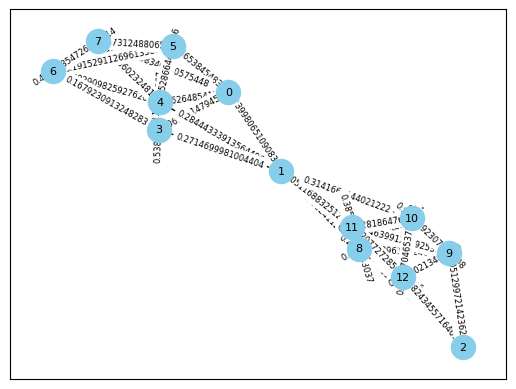

In [158]:
# Create the graph
k=5
G, group_fc_matrix_strength = create_knn_graph(fc_matrices, k)
# Visualize the graph
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.show()

In [159]:
print(len(pos))

13


In [165]:
adjacency_matrix = nx.adjacency_matrix(G).todense()
labels = list(G.nodes)

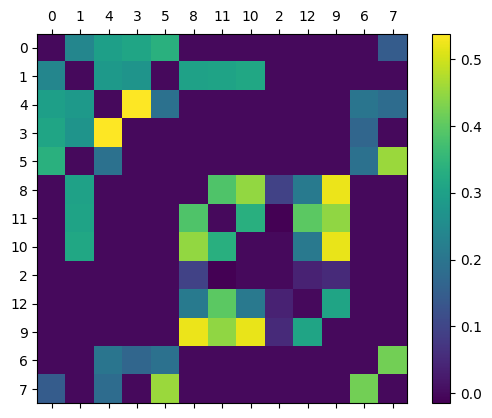

In [166]:
# Visualize the adjacency matrix
fig, ax = plt.subplots()
cax = ax.matshow(adjacency_matrix, cmap='viridis')

# Add labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Display the colorbar
fig.colorbar(cax)

plt.show()

In [162]:
print(adjacency_matrix.shape)

(13, 13)


In [163]:
print(len(msdl_labels))

39
